<a href="https://colab.research.google.com/github/silvidelgadillo/python-test/blob/main/sprint_2_silvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder

### Analyzing our data

In [ ]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

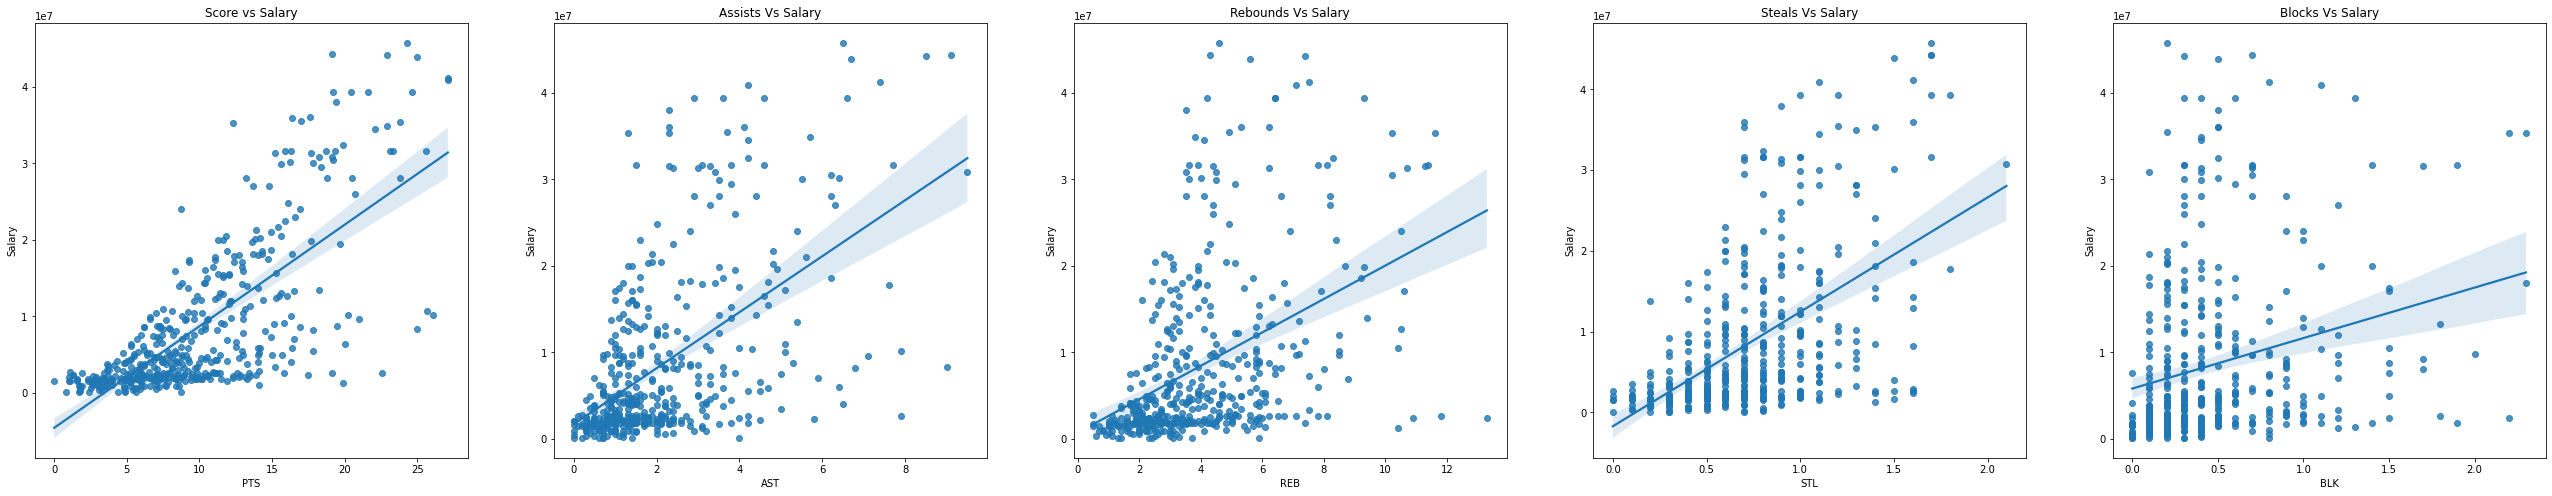

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(45,8))
sns.regplot(x='PTS', y='Salary', data=data, ax=axs[0]).set(title='Score vs Salary')
sns.regplot(x='REB', y='Salary', data=data, ax=axs[2]).set(title='Rebounds Vs Salary')
sns.regplot(x='AST', y='Salary', data=data, ax=axs[1]).set(title='Assists Vs Salary')
sns.regplot(x='STL', y='Salary', data=data, ax=axs[3]).set(title='Steals Vs Salary')
sns.regplot(x='BLK', y='Salary', data=data, ax=axs[4]).set(title='Blocks Vs Salary')
plt.show()

1.2. What can we say about these distributions?

In [ ]:
##What I can say about these distributions is that they are not linear

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [ ]:
X = data['PTS']
y = data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((321,), (138,), (321,), (138,))

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [ ]:
class BaselineModel():
    """A baseline model that always returns the same value, the mean of the players salary in the train data"""
    
    def fit(self, train_salary):
        """
        Fit the training data. 
        
        Parameters
        ----------
        y_train: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing salary information
        """
        #self.promedio = int(round(np.mean(train_salary)))
        self.mean_salary = y_train.mean()
        
    
    def predict(self, X):
        """
        Predict salaries 
        
        Parameters
        ----------
        X: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the 
            
        Returns
        -------
        np.ndarray
            a numpy array of the same length as X, with all elements equal to the mean salary calculated in fit()
        """
        '''vector_x = np.zeros(len(X))
        vector_x.fill(self.promedio)
        vector_x = vector_x.astype((int))
        return (vector_x)'''
        size_x=len(X)
        y_pred=np.array(self.mean_salary * np.ones(size_x))
        return y_pred

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [ ]:
baseline_model = BaselineModel()
baseline_model.fit(y_train)
y_pred= baseline_model.predict(X_test)

In [ ]:
base_line = round(mean_absolute_error(y_pred, y_test))


In [ ]:
base_line

6905402

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train.values.reshape(-1,1))
X_train_standard = scaler.transform(X_train.values.reshape(-1,1))
X_test_standard = scaler.transform(X_test.values.reshape(-1,1))

In [ ]:
'''train_minmax = MinMaxScaler().fit(X_train.values.reshape(-1,1))
train_minmax'''

'train_minmax = MinMaxScaler().fit(X_train.values.reshape(-1,1))\ntrain_minmax'

In [ ]:
'''X_train = train_minmax.transform(X_train.values.reshape(-1,1))
X_test = train_minmax.transform(X_test.values.reshape(-1,1))'''

'X_train = train_minmax.transform(X_train.values.reshape(-1,1))\nX_test = train_minmax.transform(X_test.values.reshape(-1,1))'

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [ ]:
SGDR = SGDRegressor()
SGDR.fit(X_train_standard, y_train)

SGDRegressor()

In [ ]:
SGDRegressor()

SGDRegressor()

In [ ]:
salary_pred = SGDR.predict(X_test_standard)

In [ ]:
default_SGDR = round(mean_absolute_error(salary_pred, y_test))

In [ ]:
default_SGDR

4662076

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [ ]:
def search_best_hyperparameters(epochs, learning_rates, alphas):
    result = {
        "hyperparameters": {"epochs": None, "lr": None, "alpha": None}, 
        "mae": None
    }
    for ep in epochs:
      for lr in learning_rates:
        print(ep, '-', lr)
        SGDR = SGDRegressor(max_iter = ep, eta0 = lr)
        SGDR.fit(X_train_standard, y_train)
        salary_pred = SGDR.predict(X_test_standard)
        mean_to_mae = (round(mean_absolute_error(salary_pred, y_test)))
        if result['mae'] == None:
          result['hyperparameters']['epochs']=ep
          result['hyperparameters']['lr'] = lr
          result['mae'] = mean_to_mae
    return result

In [ ]:
## Example list of hyperparameters values
epochs = [1000, 1000000]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(epochs, learning_rates, alphas)

1000 - 0.0001
1000 - 0.001
1000 - 0.01
1000 - 0.1
1000000 - 0.0001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


1000000 - 0.001
1000000 - 0.01
1000000 - 0.1


In [ ]:
print(result)

{'hyperparameters': {'epochs': 1000, 'lr': 0.0001, 'alpha': None}, 'mae': 4550375}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [ ]:
best_sgdr_pred = result['mae']
print("Mean Absolute Error for each model:")
print(f"Baseline: {'b_line'}")
print(f"Default SGDRegressor: {default_SGDR}")
print(f"Best SGDRegressor: {best_sgdr_pred}")

Mean Absolute Error for each model:
Baseline: b_line
Default SGDRegressor: 4662076
Best SGDRegressor: 4550375


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")

In [ ]:
data

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,201152,Thaddeus Young,Raptors,Forward,203,107,USA,1988-06-21,14,12,1066.0,29.5,12.9,5.9,1.8,1.4,0.4,2022-03-06,14190000,"33 years, 8 months, 23 days"
456,1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,3,5,262.0,33.4,25.0,3.9,9.0,0.9,0.2,2022-03-07,8326471,"23 years, 5 months, 25 days"
457,1630209,Omer Yurtseven,Heat,Center,211,125,Turkey,1998-06-19,0,Undrafted,45.0,13.7,6.0,5.7,1.0,0.3,0.4,2022-03-07,1489065,"23 years, 8 months, 25 days"
458,203469,Cody Zeller,Hornets,Forward,211,109,USA,1992-10-05,9,4,494.0,22.2,8.5,6.0,1.4,0.6,0.6,NaN,2389641,"29 years, 5 months, 11 days"


In [ ]:
data.head()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"


In [ ]:
columns_list = ['PERSON_ID', 'PTS', 'REB', 'AST', 'BLK', 'SEASON_EXP', 'POSITION', 'DRAFT_NUMBER', 'Salary', 'TEAM_NAME']

In [ ]:
data_select = data[columns_list].copy()

In [ ]:
data_select.set_index('PERSON_ID', inplace=True)

In [ ]:
data_select

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,TEAM_NAME
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,2711280,Raptors
203500,9.3,7.9,1.4,0.9,8,Center,12,17073171,Grizzlies
1628389,13.2,8.2,3.5,0.9,4,Center,14,28103550,Heat
1630583,3.3,2.4,0.5,0.3,0,Forward,30,1994520,Grizzlies
200746,19.1,8.1,1.9,1.1,15,Center,2,2641691,Nets
...,...,...,...,...,...,...,...,...,...
201152,12.9,5.9,1.8,0.4,14,Forward,12,14190000,Raptors
1629027,25.0,3.9,9.0,0.2,3,Guard,5,8326471,Hawks
1630209,6.0,5.7,1.0,0.4,0,Center,Undrafted,1489065,Heat


#### Feature Engineering

1.12. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [ ]:
data_select['DRAFT_NUMBER'] = data_select.DRAFT_NUMBER.apply(lambda x: np.nan if x == 'Undrafted'else x)

In [ ]:
data_select['DRAFT_NUMBER'] = data_select.DRAFT_NUMBER.astype(float).astype('Int64')

In [ ]:
bins = pd.IntervalIndex.from_tuples([(0,15),(15,30),(30,60)])

In [ ]:
data_select['DRAFT'] = pd.cut(data_select.DRAFT_NUMBER, bins)

In [ ]:
data_select['DRAFT']=data_select.DRAFT_NUMBER.astype(str)

In [ ]:
dict = {"(0, 15)":"firstround_lottery",
        "(15, 30)":"firstround_non_lottery",
        "(30, 60)":"second_round",
        pd.NA : "undrafted"
        }

In [ ]:
data_select['DRAFT'].replace(dict, inplace=True)

In [ ]:
data_select.drop('DRAFT_NUMBER', axis=1, inplace=True)

In [ ]:
#data_select['DRAFT_NUMBER'] = data_select['DRAFT_NUMBER'].astype(int)
#data_select['DRAFT_NUMBER']=data_select['DRAFT_NUMBER'].fillna(0).astype(int)
#data_select['DRAFT_NUMBER'].isnull().sum()

1.13. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [ ]:
data_select = pd.get_dummies(data_select, columns=['DRAFT', 'POSITION', 'TEAM_NAME'])

In [ ]:
data_select

,PTS,REB,AST,BLK,SEASON_EXP,Salary,DRAFT_1,DRAFT_10,DRAFT_11,DRAFT_12,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,2711280,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
203500,9.3,7.9,1.4,0.9,8,17073171,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1628389,13.2,8.2,3.5,0.9,4,28103550,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630583,3.3,2.4,0.5,0.3,0,1994520,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200746,19.1,8.1,1.9,1.1,15,2641691,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201152,12.9,5.9,1.8,0.4,14,14190000,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1629027,25.0,3.9,9.0,0.2,3,8326471,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630209,6.0,5.7,1.0,0.4,0,1489065,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

1.14. Split the dataset into train and test

In [ ]:
data_select_train, data_select_test = train_test_split(data_select, test_size=0.33, random_state=42)

1.11. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next)

In [ ]:
columns_list = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]
data_select_train.dropna(subset=columns_list, inplace=True)
data_select_test.dropna(subset=columns_list, inplace=True)
for col in columns_list:
  scaler.fit(data_select_train[col].values.reshape(-1, 1))
  data_select_train[col] = scaler.transform(data_select_train[col].values.reshape(-1, 1))
  data_select_test[col] = scaler.transform(data_select_test[col].values.reshape(-1, 1))

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [ ]:
X_train = data_select_train.drop(labels = "Salary", axis=1)
y_train = data_select_train["Salary"]

In [ ]:
X_test = data_select_test.drop(labels = "Salary", axis=1)
y_test = data_select_test["Salary"]

In [ ]:
SGDR = SGDRegressor()
SGDR.fit(X_train, y_train)

SGDRegressor()

1.16. How did the model performed compared to our univariate models? 

In [ ]:
y_pred = SGDR.predict(X_test)

In [ ]:
round(mean_absolute_error(y_pred, y_test))

5303416

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [ ]:
len(X_test.columns)

96

In [ ]:
##example and hyperparameters values
max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [6, 11, 22, 40]

In [ ]:
parameters = {'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features}

1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [ ]:
tree_model = DecisionTreeRegressor()

In [ ]:
grid_search = GridSearchCV(tree_model, param_grid=parameters)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 50],
                         'max_features': [6, 11, 22, 40],
                         'min_samples_leaf': [2, 10, 20, 50]})

In [ ]:
grid_search.best_params_

{'max_depth': 10, 'max_features': 40, 'min_samples_leaf': 10}

In [ ]:
y_pred_tree = grid_search.predict(X_test)

In [ ]:
round(mean_absolute_error(y_pred_tree, y_test))

4576470

### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

In [ ]:
## is linear.
#The relationship between salary is non-linear, that is, it is better adapted to the points through which the information passes,
# by reducing the error, it better fits the distance between the points, this does not mean that a linear model always works better than
#a non-linear model, since this depends on the distribution of the data, but the tendency is that the linear ones work better.

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

In [ ]:
# We must avoid the correlation between independent variables.

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [ ]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

In [ ]:
all_nba_df


,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,...,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,...,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15348,15348,2817,2,Paul Zipser,2017-18,2017,CHI,54,12,15.3,...,0.355,0.760,2.4,0.9,0.4,0.3,0.8,1.6,4.0,0
15349,15349,2818,1,Ante Zizic,2017-18,2017,CLE,32,2,6.7,...,0.731,0.724,1.9,0.2,0.1,0.4,0.3,0.9,3.7,0
15351,15351,2819,1,Jim Zoet,1982-83,1982,DET,7,0,4.3,...,0.200,0.000,1.1,0.1,0.1,0.4,0.6,1.3,0.3,0
15352,15352,2820,1,Ivica Zubac,2016-17,2016,LAL,38,11,16.0,...,0.536,0.653,4.2,0.8,0.4,0.9,0.8,1.7,7.5,0


In [ ]:
print("number of rows", len(all_nba_df))
print("number of seasons", all_nba_df.season.nunique())
print("number of unique players", all_nba_df.player_id.nunique())
print("number of all-nba selections", all_nba_df.all_nba.value_counts()[1])
print("number of all-nba selections vs non selected", all_nba_df.all_nba.value_counts()[0])

number of rows 14825
number of seasons 39
number of unique players 2718
number of all-nba selections 496
number of all-nba selections vs non selected 14329


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [ ]:
columns_list = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

In [ ]:
X_data = all_nba_df[columns_list].copy()
y_data= all_nba_df['all_nba'].copy()
data_ft_train, data_ft_test, data_t_train, data_t_test=train_test_split(X_data, y_data, test_size=0.33, random_state=42, stratify=y_data)

In [ ]:
print(data_ft_train.shape, data_ft_test.shape, data_t_train.shape, data_t_test.shape)

(9932, 15) (4893, 15) (9932,) (4893,)


In [ ]:
data_ft_train


,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
14985,TOT,78,1,24.6,0.433,0.376,0.478,0.875,2.5,3.0,1.0,0.2,2.0,1.2,17.7
2790,OKC,71,2,21.5,0.566,0.000,0.566,0.753,4.5,1.0,0.6,0.4,0.8,3.0,4.6
14715,CLE,43,14,30.1,0.463,0.000,0.464,0.652,6.7,2.3,0.8,1.6,1.5,2.9,11.7
5846,PHI,82,40,27.2,0.464,0.356,0.477,0.777,7.2,2.2,0.3,1.4,1.6,2.8,11.0
13658,PHI,23,0,5.4,0.359,0.143,0.386,0.800,1.5,0.5,0.2,0.2,0.7,0.9,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,DAL,82,42,28.3,0.471,0.250,0.483,0.820,7.4,1.6,0.8,0.8,1.2,2.9,11.0
14138,WAS,79,79,35.9,0.445,0.300,0.478,0.785,4.6,10.0,1.7,0.6,3.8,2.3,17.6
2885,LAL,81,46,19.0,0.511,0.429,0.527,0.832,3.4,0.9,0.5,0.4,0.8,2.5,7.9
13107,TOT,55,2,13.1,0.431,0.500,0.430,0.643,2.9,0.4,0.3,0.4,0.6,1.3,4.6


In [ ]:
print(data_t_train.value_counts()[1]/len(data_t_train))

0.03342730567861458


In [ ]:
print(data_t_test.value_counts()[1]/len(data_t_test))

0.03351726956877171


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [ ]:
print("Accuracy of always predict 0:",  round(data_t_train.value_counts()[0] / len(data_t_train) * 100,2 ), "%")

Accuracy of always predict 0: 96.66 %


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In [ ]:
##IF THE DATA IS VERY UNBALANCED, THE ACCURACY MAY BE VERY HIGH, BUT THE MODEL WILL BE TRAINED TO PREDICT CERTAIN VALUES WELL AND TO PREDICT OTHERS BADLY

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place

In [ ]:
data_ft_train

,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
14985,TOT,78,1,24.6,0.433,0.376,0.478,0.875,2.5,3.0,1.0,0.2,2.0,1.2,17.7
2790,OKC,71,2,21.5,0.566,0.000,0.566,0.753,4.5,1.0,0.6,0.4,0.8,3.0,4.6
14715,CLE,43,14,30.1,0.463,0.000,0.464,0.652,6.7,2.3,0.8,1.6,1.5,2.9,11.7
5846,PHI,82,40,27.2,0.464,0.356,0.477,0.777,7.2,2.2,0.3,1.4,1.6,2.8,11.0
13658,PHI,23,0,5.4,0.359,0.143,0.386,0.800,1.5,0.5,0.2,0.2,0.7,0.9,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,DAL,82,42,28.3,0.471,0.250,0.483,0.820,7.4,1.6,0.8,0.8,1.2,2.9,11.0
14138,WAS,79,79,35.9,0.445,0.300,0.478,0.785,4.6,10.0,1.7,0.6,3.8,2.3,17.6
2885,LAL,81,46,19.0,0.511,0.429,0.527,0.832,3.4,0.9,0.5,0.4,0.8,2.5,7.9
13107,TOT,55,2,13.1,0.431,0.500,0.430,0.643,2.9,0.4,0.3,0.4,0.6,1.3,4.6


In [ ]:
num_columns_list = data_ft_train.select_dtypes(include='number').columns.tolist()

In [ ]:
num_columns_list

['games',
 'gamesstarted',
 'mp',
 'fg_perc',
 '3p_perc',
 '2p_perc',
 'ft_perc',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts']

In [ ]:
scaler.fit(data_ft_train[num_columns_list])

StandardScaler()

In [ ]:
data_ft_train[num_columns_list] = scaler.transform(data_ft_train[num_columns_list])

In [ ]:
data_ft_test[num_columns_list] = scaler.transform(data_ft_test[num_columns_list])

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [ ]:
logistic_regression = LogisticRegression(random_state=0)

In [ ]:
logistic_regression.fit(data_ft_train[num_columns_list], data_t_train)

LogisticRegression(random_state=0)

In [ ]:
log_regression_prediction = logistic_regression.predict(data_ft_test[num_columns_list])

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [ ]:
accuracy = round(accuracy_score(data_t_test, log_regression_prediction), 2)

In [ ]:
metrics = precision_recall_fscore_support(data_t_test, log_regression_prediction, average='binary')

In [ ]:
precision = round(metrics[0], 2)
recall = round(metrics[1], 2)
f1 = round(metrics[2], 2)

In [ ]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('f1:', f1)

Accuracy: 0.98
Precision: 0.78
Recall: 0.59
f1: 0.67


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [ ]:
encode = OneHotEncoder(handle_unknown = 'ignore')

In [ ]:
encode

OneHotEncoder(handle_unknown='ignore')

In [ ]:
data_ft_train.columns

Index(['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
       'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'],
      dtype='object')

In [ ]:
encode.fit(data_ft_train['team'].values.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [ ]:

encode.fit(data_ft_train['team'].values.reshape(-1,1))
#Train----------

enc_array = encode.transform(data_ft_train['team'].values.reshape(-1,1)).toarray()
enc_df = pd.DataFrame(enc_array, columns=encode.get_feature_names())
enc_df.index = data_ft_train.index
data_ft_train = pd.concat([data_ft_train, enc_df], axis=1)
data_ft_train.drop('team', axis=1, inplace=True)

#Test------
enc_array = encode.transform(data_ft_test['team'].values.reshape(-1,1)).toarray()
enc_df = pd.DataFrame(enc_array, columns=encode.get_feature_names())
enc_df.index = data_ft_test.index
data_ft_test = pd.concat([data_ft_test, enc_df], axis=1)
data_ft_test.drop('team', axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [ ]:
'''def best_log_reg_param(tols, c, max_iter, x_train, y_train,x_test, y_test):
    result = {
        "hyperparameters": {"Tols": None, "C": None, "max_iter": None},
        "f1": None,
        "recall":None
    }
    for tl in tols:
        for c_element in c:
            for iter in max_iter:
                log_reg_model = LogisticRegression(tol = tl, C=c_element, max_iter=iter)
                log_reg_model.fit(x_train, y_train)
                current_pred = log_reg_model.predict(x_test)
                current_f1 = f1(current_pred, y_test)
                current_recall = recall(current_pred, nba_y_test)
                if result['f1'] != None:
                    if result['f1'] < current_f1:
                        result["hyperparameters"]["Tols"] = tl
                        result["hyperparameters"]["C"] = c_element
                        result["hyperparameters"]["max_iter"] = iter
                        result['f1'] = current_f1
                        result['recall'] = current_recall
                else:
                    result["hyperparameters"]["Tols"] = tl
                    result["hyperparameters"]["C"] = c_element
                    result["hyperparameters"]["max_iter"] = iter
                    result['f1'] = current_f1
                    result['recall'] = current_recall
    return result  

tols = [0.0001, 0.001, 0.01, 0.1]
C = [15,10, 5, 1.0]
max_iter = [100, 150, 1000,10000]

lreg_result = best_log_reg_param(tols, C, max_iter, data_ft_train, data_t_train, data_ft_test, data_t_test)
print(lreg_result)    
    
'''

'def best_log_reg_param(tols, c, max_iter, x_train, y_train,x_test, y_test):\n    result = {\n        "hyperparameters": {"Tols": None, "C": None, "max_iter": None},\n        "f1": None,\n        "recall":None\n    }\n    for tl in tols:\n        for c_element in c:\n            for iter in max_iter:\n                log_reg_model = LogisticRegression(tol = tl, C=c_element, max_iter=iter)\n                log_reg_model.fit(x_train, y_train)\n                current_pred = log_reg_model.predict(x_test)\n                current_f1 = f1(current_pred, y_test)\n                current_recall = recall(current_pred, nba_y_test)\n                if result[\'f1\'] != None:\n                    if result[\'f1\'] < current_f1:\n                        result["hyperparameters"]["Tols"] = tl\n                        result["hyperparameters"]["C"] = c_element\n                        result["hyperparameters"]["max_iter"] = iter\n                        result[\'f1\'] = current_f1\n                  

In [ ]:
def search_best_hyperparameters_log(max_iter, tol, C, x_train, x_test, y_train, y_test):
  result = {
      "hyperparameters": {"max_iter": None, "tol":None, "C":None},
      "scores": {"precision": None, "recall": None, "f1": None},
      "model": None
  }
  list_f1 =[]
  list_rest=[]
  for max_iter_v in max_iter:
    for tol_v in tol:
      for C_V in C:
        log_regr_i = LogisticRegression(random_state=0, max_iter=max_iter_v, tol=tol_v, C=C_V)
        log_regr_i.fit(x_train, y_train)
        log_reg_pred_i = log_regr_i.predict(x_test)
        metrics_i = precision_recall_fscore_support(y_test, log_reg_pred_i, average='binary')
        precision_i = round(metrics_i[0],2)
        recall_i = round(metrics_i[1],2)
        f1_i = round(metrics_i[2], 2)

        list_f1.append(f1_i)
        list_rest.append([max_iter_v, tol_v, C_V, precision_i, recall_i, log_regr_i])
        index_max_f1 = list_f1.index(max(list_f1))
        result["hyperparameters"]["max_iter"] = list_rest[index_max_f1][0]
        result["hyperparameters"]["tol"] = list_rest[index_max_f1][1]
        result["hyperparameters"]["C"] = list_rest[index_max_f1][2]
        result["scores"]["precision"] = list_rest[index_max_f1][3]
        result["scores"]["recall"] = list_rest[index_max_f1][4]
        result["scores"]["f1"] = list_f1[index_max_f1]
        result["model"] = list_rest[index_max_f1][5]
        return result

In [ ]:
max_iter_list = [1000, 5000, 10000, 15000]
tol_list = [1e-11, 1e-9, 1e-7, 1e-5]
C_list = [1, 1.5, 2, 2.5]
log_pred_results = search_best_hyperparameters_log(max_iter_list, tol_list, C_list, data_ft_train, data_ft_test, data_t_train, data_t_test)

In [ ]:
print(log_pred_results)

{'hyperparameters': {'max_iter': 1000, 'tol': 1e-11, 'C': 1}, 'scores': {'precision': 0.84, 'recall': 0.62, 'f1': 0.71}, 'model': LogisticRegression(C=1, max_iter=1000, random_state=0, tol=1e-11)}


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
#Scaling
players_df = all_nba_2018_df['player'].copy()
all_nba_2018_df.columns
all_nba_2018_df.drop(['season_id', 'player_id', 'player_season', 'player', 'season', 'season_start'], axis=1, inplace = True)
cols_to_scale = all_nba_2018_df.drop('team', axis=1).columns.to_list()
all_nba_2018_df[cols_to_scale] = scaler.transform(all_nba_2018_df[cols_to_scale])

In [ ]:
#encoder is set to handle the new 10 different team names (adding zeros in all columns)
enc_array = encode.transform(all_nba_2018_df['team'].values.reshape(-1,1)).toarray()
enc_df = pd.DataFrame(enc_array, columns=encode.get_feature_names())
enc_df.index = all_nba_2018_df.index
all_nba_2018_df = pd.concat([all_nba_2018_df, enc_df], axis=1)
all_nba_2018_df.drop('team', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(all_nba_2018_df)

          games  gamesstarted        mp   fg_perc   3p_perc   2p_perc  \
34    -0.920567     -0.814339 -0.131643 -0.867414  0.607286  0.415725   
49    -1.751985     -0.881966 -0.785236 -2.295996 -0.433071  2.095367   
70    -0.801793     -0.848152 -0.755971 -0.994399  0.689420 -0.982300   
71     1.019410      1.823112  1.273095  1.651123 -1.161320  1.381268   
79     1.098592      0.064811  0.287827  1.450064 -0.066208  1.300806   
...         ...           ...       ...       ...       ...       ...   
15319  1.059001      1.856926  1.029217 -0.221906  0.612762  0.184397   
15333 -0.207922      0.707268  0.492685  1.185511  0.333508  1.119767   
15334 -1.910351     -0.848152 -0.473072  0.995034 -1.161320  0.938727   
15350  0.187991     -0.036629 -0.199929  1.206675 -1.161320  0.948785   
15354  0.187991      0.369133 -0.268215  1.270168 -1.161320  1.009132   

        ft_perc       trb       ast       stl  ...  x0_SAC  x0_SAS  x0_SDC  \
34     1.202350 -0.811694 -0.677177 -0.357764

In [ ]:
print(players_df.unique())

['Alex Abrines' 'Quincy Acy' 'Jaylen Adams' 'Steven Adams' 'Bam Adebayo'
 'Deng Adel' 'DeVaughn Akoon-Purcell' 'LaMarcus Aldridge' 'Rawle Alkins'
 'Grayson Allen' 'Jarrett Allen' 'Kadeem Allen' 'Al-Farouq Aminu'
 'Justin Anderson' 'Kyle Anderson' 'Ryan Anderson' 'Ike Anigbogu'
 'Giannis Antetokounmpo' 'Kostas Antetokounmpo' 'Carmelo Anthony'
 'OG Anunoby' 'Ryan Arcidiacono' 'Trevor Ariza' 'D.J. Augustin'
 'Deandre Ayton' 'Dwayne Bacon' 'Marvin Bagley' 'Ron Baker' 'Wade Baldwin'
 'Lonzo Ball' 'Mo Bamba' 'J.J. Barea' 'Harrison Barnes' 'Will Barton'
 'Keita Bates-Diop' 'Nicolas Batum' 'Jerryd Bayless' 'Aron Baynes'
 'Kent Bazemore' 'Bradley Beal' 'Malik Beasley' 'Michael Beasley'
 'Marco Belinelli' 'Jordan Bell' "DeAndre' Bembry" 'Dragan Bender'
 'Dairis Bertans' 'Davis Bertans' 'Patrick Beverley' 'Khem Birch'
 'Bismack Biyombo' 'Nemanja Bjelica' 'Antonio Blakeney' 'Eric Bledsoe'
 'Jaron Blossomgame' 'Bogdan Bogdanovic' 'Bojan Bogdanovic' 'Andrew Bogut'
 'Jonah Bolden' 'Isaac Bonga' 'Devi

2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [ ]:
log_reg_pred = log_pred_results['model'].predict(all_nba_2018_df)
metrics = precision_recall_fscore_support(all_nba_2018_selections['all_nba'], log_reg_pred, average='binary')
precision = round(metrics[0], 2)
recall = round(metrics[1], 2)
f1 = round(metrics[2], 2)

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Precision: 0.62
Recall: 1.0
f1: 0.77


2.12. Analyze the results, what do you think it is happening?

In [ ]:
##the precision , recall and f1- score values were quite similar among the three models for the  category

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [ ]:
probability_array = log_pred_results['model'].predict_proba(all_nba_2018_df)
probability_array = np.around(probability_array, decimals = 3)
probability_df = pd.DataFrame(probability_array)
probability_df.index = all_nba_2018_df.index
all_nba_2018_df_w_prob = pd.concat([all_nba_2018_df, probability_df[1]], axis=1)
all_nba_2018_df_w_prob.rename(columns={1: "All-NBA-Prob"}, inplace=True)

In [ ]:
all_nba_2018_df_w_prob.head(50)

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,x0_SAS,x0_SDC,x0_SEA,x0_TOR,x0_TOT,x0_UTA,x0_VAN,x0_WAS,x0_WSB,All-NBA-Prob
34,-0.920567,-0.814339,-0.131643,-0.867414,0.607286,0.415725,1.202350,-0.811694,-0.677177,-0.357764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
49,-1.751985,-0.881966,-0.785236,-2.295996,-0.433071,2.095367,0.008122,-0.421506,-0.569819,-1.189530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
70,-0.801793,-0.848152,-0.755971,-0.994399,0.689420,-0.982300,0.425834,-0.694638,0.020651,-0.565705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
71,1.019410,1.823112,1.273095,1.651123,-1.161320,1.381268,-1.062934,2.309807,-0.140386,1.721653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072
79,1.098592,0.064811,0.287827,1.450064,-0.066208,1.300806,0.195557,1.451394,0.181688,0.474003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001
80,-1.395663,-0.780526,-0.990094,-1.407100,0.267801,-0.740915,1.614707,-1.006788,-0.838214,-1.189530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
139,-1.870759,-0.881966,-1.682708,-1.470593,-1.161320,0.415725,-1.062934,-1.162863,-0.516140,-0.773647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
168,1.059001,1.856926,1.253584,0.846885,0.141863,0.697342,0.795349,2.192751,0.289047,-0.357764,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.863
193,-1.751985,-0.848152,-0.814502,-1.121384,0.207570,-0.891781,-0.168602,-0.382488,-0.301423,-1.189530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
248,-0.643427,-0.814339,-0.921808,-0.666354,0.607286,-0.157566,0.275887,-1.162863,-0.623498,-0.981589,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [ ]:
all_nba_2018_df_w_players = pd.concat([all_nba_2018_df_w_prob, players_df], axis=1)
all_nba_2018_df_w_players.sort_values('All-NBA-Prob', ascending=False, inplace=True)
print(all_nba_2018_df_w_players[['player', 'All-NBA-Prob']].head(10))

                      player  All-NBA-Prob
453    Giannis Antetokounmpo         0.999
5604            James Harden         0.999
6857            LeBron James         0.997
3401           Anthony Davis         0.985
14479      Russell Westbrook         0.979
4145             Joel Embiid         0.975
14027         Nikola Vucevic         0.972
3908            Kevin Durant         0.965
4895             Paul George         0.946
8206          Damian Lillard         0.876


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [ ]:
log_reg_pred_df = pd.DataFrame(log_reg_pred)
log_reg_pred_df.index = all_nba_2018_df.index
all_nba_2018_df_w_predict = pd.concat([all_nba_2018_df_w_players, log_reg_pred_df], axis=1)
all_nba_2018_df_w_predict.rename(columns={0: "Prediction"}, inplace=True)
#Including real result

all_nba_2018_df_w_predict = pd.concat([all_nba_2018_df_w_predict, all_nba_2018_selections['all_nba']], axis=1)
all_nba_2018_df_w_predict.rename(columns={'all_nba':'all_nba_real'}, inplace=True)

print("***Players actually selected from the all_nba_2018_selectins dataset")
print(all_nba_2018_df_w_predict['player'].loc[all_nba_2018_df_w_predict.all_nba_real == 1])

print("\n***Players actually selected missing from OUR predictions")
mask = (all_nba_2018_df_w_predict.all_nba_real == 1) & (all_nba_2018_df_w_predict.Prediction ==0)
if all_nba_2018_df_w_predict[mask].empty:
  print("\n#All players actually selected were predicted as selected")
else:
  print(all_nba_2018_df_w_predict[mask]['player'])

print("\n**** players in our predictions not selected*****")
mask = (all_nba_2018_df_w_predict.all_nba_real == 0) & (all_nba_2018_df_w_predict.Prediction ==1)
if all_nba_2018_df_w_predict[mask].empty:
  print("\n# all Players predicted as selected were actually selected")
else:
  print(all_nba_2018_df_w_predict[mask]['player'])



***Players actually selected from the all_nba_2018_selectins dataset
453      Giannis Antetokounmpo
3168             Stephen Curry
3908              Kevin Durant
4145               Joel Embiid
4895               Paul George
5016               Rudy Gobert
5399             Blake Griffin
5604              James Harden
6634              Kyrie Irving
6857              LeBron James
7225              Nikola Jokic
8103             Kawhi Leonard
8206            Damian Lillard
14132             Kemba Walker
14479        Russell Westbrook
Name: player, dtype: object

***Players actually selected missing from OUR predictions

#All players actually selected were predicted as selected

**** players in our predictions not selected*****
168       LaMarcus Aldridge
1048           Bradley Beal
2274           Clint Capela
3401          Anthony Davis
3538          DeMar DeRozan
3794         Andre Drummond
12473           Ben Simmons
13673    Karl-Anthony Towns
14027        Nikola Vucevic
Name: player, dty

2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [ ]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        
    def predict(self, X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """
        custom_class_pred = self._model.predict_proba(X)
        custom_class_pred_df = pd.DataFrame(custom_class_pred)
        custom_class_pred_df.drop(0, inplace=True, axis=1)
        custom_class_pred_df = custom_class_pred_df.rank(ascending=False)
        custom_class_pred_df = custom_class_pred_df[1].apply(lambda x: 1 if x<=15 else 0)
        return custom_class_pred_df.to_numpy()

        

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [ ]:
custom_classifier = AllNbaSingleSeasonClassifier(log_pred_results['model'])
custom_log_reg_pred = custom_classifier.predict(all_nba_2018_df)

metrics = precision_recall_fscore_support(all_nba_2018_selections['all_nba'], custom_log_reg_pred, average='binary')
precision = round(metrics[0], 2)
recall = round(metrics[1], 2)
f1 = round(metrics[2], 2)

In [ ]:
print("Precision:", precision)
print("recall:", recall)
print("f1:", f1)

Precision: 0.73
recall: 0.73
f1: 0.73


#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

In [ ]:
##the dataset is very unbalanced (many more 0's than 1's), so the model does not train well to predict the value 1

2.19. What do you think we could do to improve our model?

In [ ]:
##oversample class 1 to have the same amount as class 0. A good option would be to create synthetic data points, for example using smote

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

In [286]:
#sm = SMOTE(random_state=1)X_train_bal,y_train_bal = sm.fit_sample(X_train,y_train.ravel())